# Let's explore the RFX MDSplus tree

## Importing and setting up stuff

In [ ]:
import MDSplus as mds
import numpy as np
import matplotlib.pyplot as plt
import sys, os, time, random
from tqdm import tqdm
import h5py as h5
print(f'Python version: {sys.version}')
print(f'MDSplus version: {mds.__version__}')
np.set_printoptions(precision=3, suppress=True)

In [ ]:
#color the terminal output
def pick_random_color():
    return '\033[38;5;{}m'.format(random.randint(8, 230))
ENDC = '\033[0m'
ERR = '\033[91m'+ 'ERR: '
OK = '\033[92m' 
WARN = '\033[93m'+ 'WARN: '

In [3]:
# define the shot number and tree
SHOT = 30810
rfx = mds.Tree('rfx', SHOT, 'readonly') # open the tree read-only
from convert_to_hdf5 import SEG_FAULT_NODES

## Traversing the tree

In [4]:
# traverse the tree, use MAX_DEPTH to limit the depth of the tree to traverse
# othwerwise the script will run for about 10 minutes
MAX_DEPTH = 3# 13 # maximum depth of the tree to traverse
COLORS = [pick_random_color() for _ in range(MAX_DEPTH)]

In [5]:
usage_depth, usage_breadth = {},{}
total_nodes_depth, total_nodes_breadth = [],[]

def traverse_tree_depth_first(max_depth, node, level=0, path='', node_type='child'):
    try: 
        if level >= max_depth: return # stop if the maximum depth is reached
        if node.getFullPath() in SEG_FAULT_NODES: return # skip the nodes that cause segfault
        if node_type == 'child': node_name = node.node_name.upper()
        elif node_type == 'member': node_name = node.node_name.lower()
        else: raise
        path = path + '/' + COLORS[level] + node_name + ENDC # add the node name
        total_nodes_depth.append(node) # add the node to the list
        print(f'{path}:{node.decompile()}') 
        # get the usage/type of the node
        try: usage_depth[str(node.usage)] += 1
        except: usage_depth[str(node.usage)] = 1
        # go through the children and members of the node
        for child in node.getChildren(): # get the children of the node
            traverse_tree_depth_first(max_depth, child, level + 1, path, 'child')
        for member in node.getMembers(): # get the members of the node
            traverse_tree_depth_first(max_depth, member, level + 1, path, 'member')
    except Exception as e:
        print(path + 'ERR:' + str(e))
        pass

# do the same but without recursion
def traverse_tree_breadth_first(max_depth, head_node):
    curr_nodes = [head_node]
    for d in range(max_depth):
        print('Depth:', d)
        next_nodes = []
        for node in curr_nodes:
            try:
                if node.getFullPath() in SEG_FAULT_NODES: continue # skip the nodes that cause segfault
                preprint = COLORS[d] + "   " * d + node.node_name + ENDC
                print(f'{preprint}:{node.decompile()}') # print the node
                total_nodes_breadth.append(node) # add the node to the list
                # get the usage/type of the node
                try: usage_breadth[str(node.usage)] += 1
                except: usage_breadth[str(node.usage)] = 1
                # get the children of the node
                for child in node.getChildren():
                    next_nodes.append(child)
                # get the members of the node
                for member in node.getMembers():
                    next_nodes.append(member)
            except: pass
        curr_nodes = next_nodes
        
# get the top node of the tree
head_node = rfx.getNode('\\TOP.RFX.MHD') # get the top node
# # test the functions, uncomment to run
traverse_tree_depth_first(MAX_DEPTH, head_node) # traverse the tree depth-first
traverse_tree_breadth_first(MAX_DEPTH, head_node) # traverse the tree breadth-first

print(f'Total nodes depth: {len(total_nodes_depth)}') # 96771, 96750
print(f'Total nodes breadth: {len(total_nodes_breadth)}') # 96771, 96750

/MHD:\MHD
/MHD/MHD_AC:\MHD_AC::TOP
/MHD/MHD_AC/MHD_AC_EL:\MHD_AC::TOP.MHD_AC_EL
/MHD/MHD_AC/cpci_1:\MHD_AC::TOP:CPCI_1
/MHD/MHD_AC/cpci_2:\MHD_AC::TOP:CPCI_2
/MHD/MHD_AC/vme:\MHD_AC::TOP:VME
/MHD/MHD_BC:\MHD_BC::TOP
/MHD/MHD_BC/MHD_BC_EL:\MHD_BC::TOP.MHD_BC_EL
/MHD/MHD_BC/cpci_1:\MHD_BC::TOP:CPCI_1
/MHD/MHD_BC/cpci_2:\MHD_BC::TOP:CPCI_2
/MHD/MHD_BC/vme:\MHD_BC::TOP:VME
/MHD/MHD_BR:\MHD_BR::TOP
/MHD/MHD_BR/MHD_BR_EL:\MHD_BR::TOP.MHD_BR_EL
/MHD/MHD_BR/cpci_1:\MHD_BR::TOP:CPCI_1
/MHD/MHD_BR/vme:\MHD_BR::TOP:VME
Depth: 0
MHD:\MHD
Depth: 1
   MHD_AC:\MHD_AC::TOP
   MHD_BC:\MHD_BC::TOP
   MHD_BR:\MHD_BR::TOP
Depth: 2
      MHD_AC_EL:\MHD_AC::TOP.MHD_AC_EL
      CPCI_1:\MHD_AC::TOP:CPCI_1
      CPCI_2:\MHD_AC::TOP:CPCI_2
      VME:\MHD_AC::TOP:VME
      MHD_BC_EL:\MHD_BC::TOP.MHD_BC_EL
      CPCI_1:\MHD_BC::TOP:CPCI_1
      CPCI_2:\MHD_BC::TOP:CPCI_2
      VME:\MHD_BC::TOP:VME
      MHD_BR_EL:\MHD_BR::TOP.MHD_BR_EL
      CPCI_1:\MHD_BR::TOP:CPCI_1
      VME:\MHD_BR::TOP:VME
Total nodes depth:

In [6]:
print(f'Usage depth: {usage_depth}')
print(f'Usage breadth: {usage_breadth}')

Usage depth: {'STRUCTURE': 9, 'SUBTREE': 6}
Usage breadth: {'STRUCTURE': 9, 'SUBTREE': 6}


previous cell full depth: 'STRUCTURE': 8776, 'SUBTREE': 78, 'DEVICE': 642, 'ACTION': 1098, 'NUMERIC': 47760, 'TEXT': 17269, 'SIGNAL': 20904, 'ANY': 29, 'AXIS': 215

In [7]:
print(f'top nodes: {[n.node_name for n in head_node.getChildren()]}')

top nodes: ["MHD_AC", "MHD_BC", "MHD_BR"]


## Exploring Signals

In [8]:
search_space = '\\TOP.RFX.MHD.***' # *** means all nodes at this level
# search_space = '\\TOP.RFX.EDA.***' # * means all nodes at this level
# search_space = '\\TOP.RFX.***' # whole rfx tree
signal_nodes = rfx.getNodeWild(search_space, 'Signal') # get all nodes with the name 'Signal'
print(f'Found {len(signal_nodes)} of the type Signal in the search space {search_space}')

Found 5491 of the type Signal in the search space \TOP.RFX.MHD.***


In [9]:
# filter out the nodes without the data
data_signals = []
for node in tqdm(signal_nodes, leave=False):
    try: data = node.data(); data_signals.append(node)
    except: pass
print(f'Found {len(data_signals)}/{len(signal_nodes)} signals with data')

Found 4356/5491 signals with data


In [10]:
# keep only the signals with raw data
raw_signals = []
for node in tqdm(signal_nodes, leave=False):
    try: data = node.raw_of().data(); raw_signals.append(node)
    except: pass
print(f'Found {len(raw_signals)}/{len(data_signals)} signals with raw data')

Found 3971/4356 signals with raw data


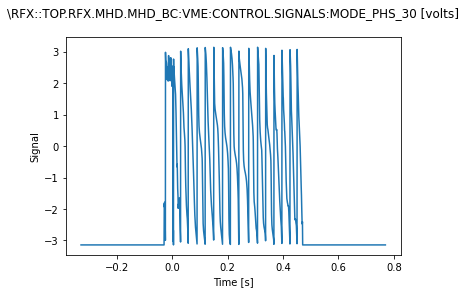

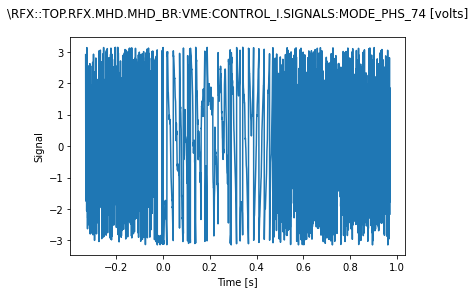

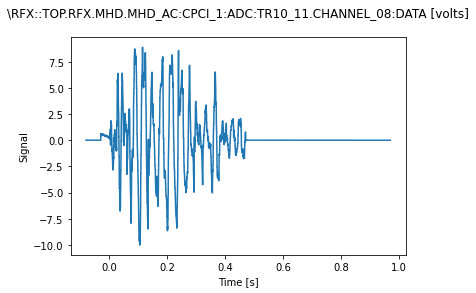

In [11]:
# extract data from the signals and plot them
MAX_LOAD = 3 #10 #np.inf
MAX_LOAD = min(MAX_LOAD, len(raw_signals))
# select MAX_LOAD random signals
signals = random.sample(raw_signals, MAX_LOAD)
for node in (signals):
    signal = node.data()
    times = node.dim_of().data()
    unit = node.getUnits()
    full_path = node.getFullPath()
    try: node_help = node.getHelp()
    except: node_help = ''
    if signal.shape != times.shape:
        print(f'{full_path} has mismatched signal and time shapes')
        continue
    # plot the signal
    plt.figure()
    plt.plot(times, signal)
    plt.title(f'{full_path} [{unit}]\n{node_help}')
    plt.xlabel('Time [s]')
    plt.ylabel('Signal')
    plt.show()

## Exploring Text

In [12]:
text_nodes = rfx.getNodeWild(search_space, 'Text') # get all the 'TEXT' nodes
print(f'Found {len(text_nodes)} of the type Text in the search space {search_space}')
# print all the text nodes
for node in text_nodes:
    try: print(f'{node.getFullPath()}={node.data()}')
    except: pass

Found 2669 of the type Text in the search space \TOP.RFX.MHD.***
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL:COMMENT=#1 SlinkyRot #2 Zanca2008 #3 Hybrid 2010
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL:FEEDFORW=DISABLED
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL:ROUTINE_NAME=MhdAc
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL:VERSION=2.3.0
\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL:VME_IP=150.178.34.29
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:DESCRIPTION=Null waveforms
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:VME_IP=150.178.34.29
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10_1:CLOCK_MODE=EXTERNAL
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10_1:COMMENT=
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10_1:IP_ADDR=
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10_1:SW_MODE=LOCAL
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10_1:TRIG_EDGE=RISING
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10_1:TRIG_MODE=EXTERNAL
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10_1:USE_TIME=TRUE
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10_10:CLOCK_MODE=EXTERNAL
\RFX::TOP.RFX.MHD.MHD_AC:CPCI_1:ADC:TR10

## Exploring Times

In [13]:
import MDSplus as mds
import numpy as np
import sys
from tqdm import tqdm
print(f'Python version: {sys.version}')
print(f'MDSplus version: {mds.__version__}')
np.set_printoptions(precision=3, suppress=True)

Python version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
MDSplus version: 1.0.0


In [14]:
# define the shot number and tree
SHOT = 30810
rfx = mds.Tree('rfx', SHOT, 'readonly') # open the tree read-only
from convert_to_hdf5 import SEG_FAULT_NODES
MAX_DEPTH = 13 # maximum depth of the tree to traverse

In [15]:
times, datas = [], []
def traverse_get_times(max_depth, head_node):
    curr_nodes = [head_node]
    for d in range(max_depth):
        next_nodes = []
        for node in tqdm(curr_nodes, ncols=80, desc=f'Depth:{d}'):
            if node.getFullPath() in SEG_FAULT_NODES: continue # skip the nodes that cause segfault
            try: #get the time vector of the node
                timev = node.dim_of().data()
                datav = node.data()
                assert len(timev) == len(datav), f'len(timev)={len(timev)} != len(datav)={len(datav)}'
                try :
                    assert timev.ndim == 1, f'ignored: timev.ndim={timev.ndim}'
                    assert len(timev) > 1000, f'ignored: len(timev)={len(timev)}'
                    times.append(timev), datas.append(datav)
                except Exception as e:
                    print(f'{node.getFullPath()} ERR: {e}')
                    pass
            except: pass
            try: # get the children of the node
                for child in node.getChildren(): next_nodes.append(child)
            except: pass
            try:# get the members of the node
                for member in node.getMembers(): next_nodes.append(member)
            except: pass
        curr_nodes = next_nodes

# traverse_get_times(MAX_DEPTH, rfx.getNode('\\TOP.RFX')) # get the top node)
traverse_get_times(6, rfx.getNode('\\TOP.RFX')) # get the top node)

Depth:3:  60%|██████████████████▌            | 372/623 [00:02<00:01, 199.21it/s]

\RFX::TOP.RFX.SETUP:UNITS:A_PARS ERR: ignored: len(timev)=288
\RFX::TOP.RFX.SETUP:UNITS:B_PARS ERR: ignored: len(timev)=192


Depth:3:  66%|████████████████████▍          | 411/623 [00:02<00:01, 150.03it/s]

\RFX::TOP.RFX.STC:DIO2_1:REC_EVENTS ERR: ignored: len(timev)=9
\RFX::TOP.RFX.STC:DIO2_1:REC_TIMES ERR: ignored: len(timev)=9
\RFX::TOP.RFX.STC:DIO2_2:REC_EVENTS ERR: ignored: len(timev)=9
\RFX::TOP.RFX.STC:DIO2_2:REC_TIMES ERR: ignored: len(timev)=9


Depth:3:  71%|██████████████████████         | 443/623 [00:02<00:01, 133.38it/s]

\RFX::TOP.RFX.STC:DIO2_3:REC_EVENTS ERR: ignored: len(timev)=9
\RFX::TOP.RFX.STC:DIO2_3:REC_TIMES ERR: ignored: len(timev)=9
\RFX::TOP.RFX.STC:DIO2_4:REC_EVENTS ERR: ignored: len(timev)=9
\RFX::TOP.RFX.STC:DIO2_4:REC_TIMES ERR: ignored: len(timev)=9


Depth:3:  78%|████████████████████████▎      | 489/623 [00:03<00:01, 131.11it/s]

\RFX::TOP.RFX.STC:DIO2_5:REC_EVENTS ERR: ignored: len(timev)=9
\RFX::TOP.RFX.STC:DIO2_5:REC_TIMES ERR: ignored: len(timev)=9
\RFX::TOP.RFX.STC:DIO2_6:REC_EVENTS ERR: ignored: len(timev)=9
\RFX::TOP.RFX.STC:DIO2_6:REC_TIMES ERR: ignored: len(timev)=9


Depth:3:  87%|██████████████████████████▊    | 539/623 [00:03<00:00, 147.82it/s]

\RFX::TOP.RFX.STC:DIO2_7:REC_EVENTS ERR: ignored: len(timev)=9
\RFX::TOP.RFX.STC:DIO2_7:REC_TIMES ERR: ignored: len(timev)=9


Depth:3:  95%|█████████████████████████████▌ | 593/623 [00:03<00:00, 165.82it/s]

\RFX::TOP.RFX.STC:TIMING:EVENT_NAMES ERR: ignored: len(timev)=13
\RFX::TOP.RFX.STC:TIMING:EVENT_TIMES ERR: ignored: len(timev)=13


Depth:4:   7%|██                            | 170/2422 [00:01<00:14, 153.01it/s]

\RFX::TOP.RFX.DIAG.DCCD.SIGNALS:SPECTRUM_1 ERR: ignored: len(timev)=200


Depth:4:  15%|████▍                         | 357/2422 [00:02<00:13, 157.11it/s]

\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:ANG_LAMINE ERR: ignored: len(timev)=40
\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:CALIB_CHISQ ERR: ignored: len(timev)=6
\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:CALIB_FACTS ERR: ignored: len(timev)=6
\RFX::TOP.RFX.DIAG.DPFR.CALIBRATION:CALIB_ZERO ERR: ignored: len(timev)=6
\RFX::TOP.RFX.DIAG.DPFR.PARAMETERS:AMPLI_S1 ERR: ignored: len(timev)=6
\RFX::TOP.RFX.DIAG.DPFR.PARAMETERS:AMPLI_S2 ERR: ignored: len(timev)=6
\RFX::TOP.RFX.DIAG.DPFR.PARAMETERS:ANGLES_ZERO ERR: ignored: len(timev)=6
\RFX::TOP.RFX.DIAG.DPFR.PARAMETERS:CALIB_FACTS ERR: ignored: len(timev)=6


Depth:4:  18%|█████▎                        | 425/2422 [00:03<00:13, 153.16it/s]

\RFX::TOP.RFX.DIAG.DSFM.SIGNALS:GC2_9 ERR: ignored: len(timev)=985
\RFX::TOP.RFX.DIAG.DSFM.SIGNALS:GLI_9_82 ERR: ignored: len(timev)=925
\RFX::TOP.RFX.DIAG.DSTC.SIGNALS:MC0_VIDEO_00 ERR: ignored: len(timev)=30
\RFX::TOP.RFX.DIAG.DSTC.SIGNALS:MC0_VIDEO_01 ERR: ignored: len(timev)=30
\RFX::TOP.RFX.DIAG.DSTC.SIGNALS:MC0_VIDEO_02 ERR: ignored: len(timev)=14


Depth:4:  19%|█████▊                         | 454/2422 [00:03<00:22, 86.98it/s]

\RFX::TOP.RFX.DIAG.DSTC.SIGNALS:MC0_VIDEO_03 ERR: ignored: len(timev)=30
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:PREL ERR: ignored: len(timev)=9


Depth:4:  20%|██████                        | 486/2422 [00:03<00:17, 113.83it/s]

\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TIME_TE ERR: ignored: len(timev)=276
\RFX::TOP.RFX.DIAG.DSXM.PARAMETERS:CHECK_TYPE ERR: ignored: len(timev)=3
\RFX::TOP.RFX.DIAG.DSXM.PARAMETERS:TE_DF$ ERR: ignored: len(timev)=301
\RFX::TOP.RFX.DIAG.DSXM.PARAMETERS:TE_DF_ERR$ ERR: ignored: len(timev)=301
\RFX::TOP.RFX.DIAG.DSXM.PARAMETERS:TE_LIST ERR: ignored: len(timev)=10
\RFX::TOP.RFX.DIAG.DSXM.RESULTS:TEM150_300 ERR: ignored: len(timev)=301
\RFX::TOP.RFX.DIAG.DSXM.RESULTS:TEM150_300_E ERR: ignored: len(timev)=301
\RFX::TOP.RFX.DIAG.DSXM.RESULTS:TEM37_75 ERR: ignored: len(timev)=329
\RFX::TOP.RFX.DIAG.DSXM.RESULTS:TEM37_75_E ERR: ignored: len(timev)=329
\RFX::TOP.RFX.DIAG.DSXM.RESULTS:TEM75_150 ERR: ignored: len(timev)=332
\RFX::TOP.RFX.DIAG.DSXM.RESULTS:TEM75_150_E ERR: ignored: len(timev)=332


Depth:4:  23%|███████                       | 567/2422 [00:04<00:14, 125.18it/s]

\RFX::TOP.RFX.DIAG.DTSR.RESULTS:LASER_ENERGY ERR: ignored: len(timev)=41
\RFX::TOP.RFX.DIAG.DTSR.RESULTS:LASER_TIMES ERR: ignored: len(timev)=41


Depth:4:  29%|████████▉                      | 702/2422 [00:06<00:17, 97.77it/s]

\RFX::TOP.RFX.SETUP.MHD:CONFIG:CHOP_STATE ERR: ignored: len(timev)=192
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_109_120 ERR: ignored: len(timev)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_121_132 ERR: ignored: len(timev)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_133_144 ERR: ignored: len(timev)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_13_24 ERR: ignored: len(timev)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_145_156 ERR: ignored: len(timev)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_157_168 ERR: ignored: len(timev)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_169_180 ERR: ignored: len(timev)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_181_192 ERR: ignored: len(timev)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_1_12 ERR: ignored: len(timev)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_25_36 ERR: ignored: len(timev)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_37_48 ERR: ignored: len(timev)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_49_60 ERR: ignored: len(timev)=552
\RFX::TOP.RFX.SETUP.MHD:CONFIG:REC_61_72 ERR: ignored: len(timev)=552
\RFX::

Depth:4:  34%|██████████▏                   | 821/2422 [00:06<00:08, 180.95it/s]

\RFX::TOP.RFX.SETUP.POLOIDAL:PC_FF_SETUP:OUT_GAINS ERR: ignored: len(timev)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PC_FF_SETUP:WAVE ERR: ignored: len(timev)=2
\RFX::TOP.RFX.SETUP.POLOIDAL:PM_SETUP:OUT_GAINS ERR: ignored: len(timev)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PM_SETUP:WAVE ERR: ignored: len(timev)=5


Depth:4:  36%|██████████▋                   | 861/2422 [00:06<00:08, 183.62it/s]

\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP:OUT_GAINS ERR: ignored: len(timev)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP:OUT_GAINS ERR: ignored: len(timev)=3
\RFX::TOP.RFX.SETUP.TOROIDAL:CHOPPER:OUT_CALIB ERR: ignored: len(timev)=24
\RFX::TOP.RFX.SETUP.TOROIDAL:CHOPPER:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:CONFIG:DC8MF1 ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:CONFIG:DC8MF2 ERR: ignored: len(timev)=6


Depth:4:  36%|██████████▉                   | 881/2422 [00:07<00:08, 187.69it/s]

\RFX::TOP.RFX.SETUP.TOROIDAL:CONFIG:REC_PARAMS1 ERR: ignored: len(timev)=450
\RFX::TOP.RFX.SETUP.TOROIDAL:CONFIG:REC_PARAMS2 ERR: ignored: len(timev)=450
\RFX::TOP.RFX.SETUP.TOROIDAL:CONFIG:SEND_PARAMS1 ERR: ignored: len(timev)=66
\RFX::TOP.RFX.SETUP.TOROIDAL:CONFIG:SEND_PARAMS2 ERR: ignored: len(timev)=66


Depth:4:  39%|███████████▌                  | 937/2422 [00:07<00:09, 160.22it/s]

\RFX::TOP.RFX.SETUP.TOROIDAL:TF_SETUP:WAVE ERR: ignored: len(timev)=11
\RFX::TOP.RFX.SETUP.VESSEL:VI_SETUP:FILL_WAVE ERR: ignored: len(timev)=8
\RFX::TOP.RFX.SETUP.VESSEL:VI_SETUP:PUFF_WAVE ERR: ignored: len(timev)=17


Depth:4:  45%|████████████▉                | 1081/2422 [00:08<00:06, 202.27it/s]

\RFX::TOP.RFX.SETUP:DIAG_TIMES.DTSR:DELAY_PULSE ERR: ignored: len(timev)=10


Depth:4:  48%|██████████████               | 1172/2422 [00:08<00:07, 167.85it/s]

\RFX::TOP.RFX.STC.STC_DIAG:DIO2_1:REC_TIMES ERR: ignored: len(timev)=0
\RFX::TOP.RFX.STC.STC_DIAG:DIO2_2:REC_TIMES ERR: ignored: len(timev)=0


Depth:5:  12%|███▌                          | 668/5658 [00:06<00:36, 136.09it/s]

\RFX::TOP.RFX.DIAG.DGPI.PARAMETERS.GEOMETRY:FOCUS_CENTER ERR: ignored: len(timev)=2


Depth:5:  15%|████▍                         | 840/5658 [00:07<00:37, 129.45it/s]

\RFX::TOP.RFX.DIAG.DICO28.PARAMETERS.CONFIG:MCHORD_H ERR: ignored: len(timev)=18
\RFX::TOP.RFX.DIAG.DICO28.PARAMETERS.CONFIG:MCHORD_NAMES ERR: ignored: len(timev)=18
\RFX::TOP.RFX.DIAG.DICO28.PARAMETERS.CONFIG:MCHORD_TH ERR: ignored: len(timev)=18


Depth:5:  15%|████▋                         | 876/5658 [00:07<00:32, 145.83it/s]

\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.INV_PROG:ALPHAS_INV ERR: ignored: len(timev)=6
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.INV_PROG:BETAS_INV ERR: ignored: len(timev)=9
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.INV_PROG:CH_ERRORS ERR: ignored: len(timev)=13
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.INV_PROG:CH_NAMES ERR: ignored: len(timev)=14
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.INV_PROG:CH_TMED ERR: ignored: len(timev)=13
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.INV_PROG:CH_TZERO ERR: ignored: len(timev)=13
\RFX::TOP.RFX.DIAG.DICO28.PROGRAMS.INV_PROG:LOC_NAMES ERR: ignored: len(timev)=14


Depth:5:  16%|████▊                         | 912/5658 [00:07<00:37, 125.54it/s]

\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_0B ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_1 ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_1B ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_2 ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_2B ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_3 ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_3B ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_4 ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_4B ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_5 ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_5B ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.FJUMPS:JUMPS_CO2_6 ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.

Depth:5:  17%|█████▏                         | 953/5658 [00:08<01:16, 61.61it/s]

\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:ALPHA ERR: ignored: len(timev)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:BETA ERR: ignored: len(timev)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:CHIQ ERR: ignored: len(timev)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:D1 ERR: ignored: len(timev)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:DA ERR: ignored: len(timev)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:ERR ERR: ignored: len(timev)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:N0 ERR: ignored: len(timev)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:N1 ERR: ignored: len(timev)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:NA ERR: ignored: len(timev)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:N_AVE ERR: ignored: len(timev)=242
\RFX::TOP.RFX.DIAG.DICO28.RESULTS.INV_PROG:N_PEAK ERR: ignored: len(timev)=242


Depth:5:  28%|████████                     | 1563/5658 [00:53<00:31, 131.72it/s]

\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.DAC:ARRAY_SIZE ERR: ignored: len(timev)=1
\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.DIO:DIRECTION ERR: ignored: len(timev)=1
\RFX::TOP.RFX.DIAG.DMOSS.PARAMETERS.DIO:STATE ERR: ignored: len(timev)=1
\RFX::TOP.RFX.DIAG.DMOSS.RESULTS.CALIBRATION:I0 ERR: ignored: len(timev)=4
\RFX::TOP.RFX.DIAG.DMOSS.RESULTS.CALIBRATION:PHI0 ERR: ignored: len(timev)=4
\RFX::TOP.RFX.DIAG.DMOSS.RESULTS.CALIBRATION:PHI1 ERR: ignored: len(timev)=4
\RFX::TOP.RFX.DIAG.DMOSS.RESULTS.CALIBRATION:ZETA ERR: ignored: len(timev)=4


Depth:5:  29%|████████▍                    | 1642/5658 [00:54<00:25, 154.54it/s]

\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:FILTER_T ERR: ignored: len(timev)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:LENS_F ERR: ignored: len(timev)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:LENS_IRIS ERR: ignored: len(timev)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:PSD_2LENS ERR: ignored: len(timev)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:PSD_CAL ERR: ignored: len(timev)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:PSD_NAMES ERR: ignored: len(timev)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:PSD_PA ERR: ignored: len(timev)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:PSD_TA ERR: ignored: len(timev)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:PSD_X ERR: ignored: len(timev)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:PSD_Y ERR: ignored: len(timev)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:PSD_Z ERR: ignored: len(timev)=4
\RFX::TOP.RFX.DIAG.DPEL.PSD_2D.PARAMETERS:WINDOW_T ERR: ignored: len(timev)=4


Depth:5:  30%|████████▊                    | 1714/5658 [00:54<00:25, 153.89it/s]

\RFX::TOP.RFX.DIAG.DSCV.DSCV_RAW.PARAMETERS:DELTA ERR: ignored: len(timev)=1
\RFX::TOP.RFX.DIAG.DSCV.DSCV_RAW.PARAMETERS:TIMES ERR: ignored: len(timev)=1
\RFX::TOP.RFX.DIAG.DSCV.PARAMETERS.PARAM_CT:INSTR_W_CT ERR: ignored: len(timev)=9


Depth:5:  31%|█████████                    | 1778/5658 [00:55<00:20, 189.08it/s]

\RFX::TOP.RFX.DIAG.DSFM.PARAMETERS.PARAM_DSFM:CONTCHORD ERR: ignored: len(timev)=1
\RFX::TOP.RFX.DIAG.DSFM.PARAMETERS.PARAM_DSFM:HACHORD ERR: ignored: len(timev)=3
\RFX::TOP.RFX.DIAG.DSFM.PARAMETERS.PARAM_DSFM:PHALFA ERR: ignored: len(timev)=3


Depth:5:  35%|██████████                   | 1958/5658 [00:56<00:19, 188.36it/s]

\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.CALC_TE:CHECK_TYPE ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DSXC.PARAMETERS.CALC_TE:EXCL_LOG ERR: ignored: len(timev)=1
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_01:BE ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_01:ERR_TE ERR: ignored: len(timev)=273
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_01:LOG ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_01:TE ERR: ignored: len(timev)=273
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_02:BE ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_02:ERR_TE ERR: ignored: len(timev)=247
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_02:LOG ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_02:TE ERR: ignored: len(timev)=247
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_03:BE ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_03:ERR_TE ERR: ignored: len(timev)=245
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_03:LOG ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_03:TE ERR: ignored: len(timev)=2

Depth:5:  35%|██████████▏                  | 1999/5658 [00:56<00:18, 193.76it/s]

\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_06:LOG ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_06:TE ERR: ignored: len(timev)=249
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_07:BE ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_07:ERR_TE ERR: ignored: len(timev)=250
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_07:LOG ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_07:TE ERR: ignored: len(timev)=250
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_08:BE ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_08:ERR_TE ERR: ignored: len(timev)=208
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_08:LOG ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_08:TE ERR: ignored: len(timev)=208
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_09:BE ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_09:ERR_TE ERR: ignored: len(timev)=35
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_09:LOG ERR: ignored: len(timev)=2
\RFX::TOP.RFX.DIAG.DSXC.RESULTS:TE_09:TE ERR: ignored: len(timev)=35


Depth:5:  36%|██████████▍                  | 2040/5658 [00:56<00:18, 190.77it/s]

\RFX::TOP.RFX.DIAG.DSXM.DSXM_RAW.PARAMETERS:FEMTO_SET ERR: ignored: len(timev)=8


Depth:5:  38%|███████████▏                 | 2178/5658 [00:57<00:18, 190.63it/s]

\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.BRIGHT:EXCL_LOG ERR: ignored: len(timev)=38
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.BRIGHT:TIME ERR: ignored: len(timev)=98
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.CALC_TE:CHECK_TYPE ERR: ignored: len(timev)=3
\RFX::TOP.RFX.DIAG.DSXT.PARAMETERS.CALC_TE:EXCL_LOG ERR: ignored: len(timev)=4
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.BRIGHT:P_H ERR: ignored: len(timev)=16
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.BRIGHT:P_V ERR: ignored: len(timev)=49
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.INVERT:EMISS ERR: ignored: len(timev)=98
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.INVERT:X_AXIS ERR: ignored: len(timev)=110
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.INVERT:Y_AXIS ERR: ignored: len(timev)=110
\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:PREL ERR: ignored: len(timev)=17


Depth:5:  40%|███████████▍                 | 2236/5658 [00:57<00:19, 176.31it/s]

\RFX::TOP.RFX.DIAG.DSXT.RESULTS.TE:TIME_TE ERR: ignored: len(timev)=852


Depth:5:  41%|████████████                 | 2344/5658 [00:58<00:23, 141.28it/s]

\RFX::TOP.RFX.DIAG.DTSR.PARAMETERS.NEODIMIUM:RAD_POS ERR: ignored: len(timev)=78
\RFX::TOP.RFX.DIAG.DTSR.PARAMETERS.NEODIMIUM:STRAY ERR: ignored: len(timev)=2


Depth:5:  57%|████████████████▉             | 3205/5658 [01:07<00:33, 73.04it/s]

\RFX::TOP.RFX.EDA.EDA3:VME:CONTROL:ZERO ERR: ignored: len(timev)=384


Depth:5:  60%|██████████████████            | 3403/5658 [01:11<00:41, 54.81it/s]

\RFX::TOP.RFX.EDA.EDAV.VME:CONTROL:ZERO ERR: ignored: len(timev)=384


Depth:5:  64%|███████████████████▏          | 3620/5658 [01:14<00:21, 94.69it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CONTROL:ZERO ERR: ignored: len(timev)=384
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I011 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I012 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I013 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I014 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I021 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I022 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I023 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I024 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I031 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I032 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I033 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I034 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I041 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.M

Depth:5:  65%|██████████████████▋          | 3657/5658 [01:14<00:16, 124.91it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I094 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I101 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I102 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I103 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I104 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I111 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I112 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I113 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I114 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I121 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I122 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I123 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I124 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I131 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  65%|██████████████████▉          | 3695/5658 [01:14<00:13, 149.24it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I191 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I192 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I193 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I194 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I201 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I202 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I203 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I204 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I211 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I212 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I213 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I214 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I221 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I222 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  66%|███████████████████▏         | 3733/5658 [01:15<00:11, 165.81it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I283 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I284 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I291 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I292 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I293 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I294 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I301 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I302 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I303 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I304 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I311 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I312 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I313 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I314 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  67%|███████████████████▎         | 3771/5658 [01:15<00:10, 175.99it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I381 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I382 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I383 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I384 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I391 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I392 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I393 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I394 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I401 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I402 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I403 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I404 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I411 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I412 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  67%|███████████████████▍         | 3790/5658 [01:15<00:11, 166.11it/s]

\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I473 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I474 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I481 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I482 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I483 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_AC:VME:CURR_FF:I484 ERR: ignored: len(timev)=88


Depth:5:  72%|█████████████████████▍        | 4053/5658 [01:18<00:17, 90.89it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CONTROL:ZERO ERR: ignored: len(timev)=384
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I011 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I012 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I013 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I014 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I021 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I022 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I023 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I024 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I031 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I032 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I033 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I034 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I041 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.M

Depth:5:  72%|████████████████████▉        | 4089/5658 [01:18<00:13, 120.57it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I091 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I092 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I093 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I094 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I101 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I102 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I103 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I104 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I111 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I112 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I113 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I114 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I121 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I122 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  73%|█████████████████████▏       | 4124/5658 [01:18<00:10, 141.56it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I174 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I181 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I182 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I183 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I184 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I191 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I192 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I193 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I194 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I201 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I202 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I203 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I204 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I211 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  74%|█████████████████████▎       | 4160/5658 [01:19<00:09, 157.74it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I262 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I263 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I264 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I271 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I272 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I273 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I274 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I281 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I282 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I283 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I284 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I291 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I292 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I293 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  74%|█████████████████████▌       | 4196/5658 [01:19<00:08, 163.72it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I352 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I353 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I354 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I361 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I362 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I363 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I364 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I371 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I372 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I373 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I374 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I381 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I382 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I383 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  74%|█████████████████████▌       | 4214/5658 [01:19<00:08, 167.07it/s]

\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I441 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I442 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I443 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I444 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I451 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I452 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I453 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I454 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I461 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I462 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I463 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I464 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I471 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MHD_BC:VME:CURR_FF:I472 ERR: ignored: len(timev)=88
\RFX::TOP.RFX.MHD.MH

Depth:5:  75%|██████████████████████▋       | 4268/5658 [01:21<00:38, 36.21it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL:ZERO ERR: ignored: len(timev)=384


Depth:5:  77%|███████████████████████       | 4360/5658 [01:22<00:15, 84.05it/s]

\RFX::TOP.RFX.MHD.MHD_BR:VME:CONTROL_I:ZERO ERR: ignored: len(timev)=384
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.BV_ADD:WAVE ERR: ignored: len(timev)=8
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_IP:WAVE ERR: ignored: len(timev)=8
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_I_FS1:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_I_FS2:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_I_FS3:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_I_FS4:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_I_FS5:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_I_FS6:WAVE ERR: ignored: len(timev)=6


Depth:5:  78%|██████████████████████▌      | 4405/5658 [01:22<00:09, 127.76it/s]

\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_I_FS7:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.DELTA_I_FS8:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.I_FS1_ADD:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.I_FS2_ADD:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.I_FS3_ADD:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.I_FS4_ADD:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.I_FS5_ADD:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.I_FS6_ADD:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.I_FS7_ADD:WAVE ERR: ignored: len(timev)=6


Depth:5:  79%|██████████████████████▊      | 4451/5658 [01:23<00:07, 165.97it/s]

\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.I_FS8_ADD:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:AXI_CONTROL.REF_DELTA_H:WAVE ERR: ignored: len(timev)=5
\RFX::TOP.RFX.SETUP.POLOIDAL:IP_CONTROL.RFP:WAVE ERR: ignored: len(timev)=7
\RFX::TOP.RFX.SETUP.POLOIDAL:IP_CONTROL.TOKAMAK:WAVE ERR: ignored: len(timev)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PC_SETUP.WAVE_1:OUT_GAINS ERR: ignored: len(timev)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PC_SETUP.WAVE_1:WAVE ERR: ignored: len(timev)=7
\RFX::TOP.RFX.SETUP.POLOIDAL:PC_SETUP.WAVE_2:WAVE ERR: ignored: len(timev)=7


Depth:5:  79%|███████████████████████      | 4497/5658 [01:23<00:06, 191.46it/s]

\RFX::TOP.RFX.SETUP.POLOIDAL:PC_SETUP.WAVE_3:WAVE ERR: ignored: len(timev)=7
\RFX::TOP.RFX.SETUP.POLOIDAL:PC_SETUP.WAVE_4:WAVE ERR: ignored: len(timev)=7
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP.CHANNEL_1:WAVE ERR: ignored: len(timev)=4
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP.CHANNEL_2:WAVE ERR: ignored: len(timev)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP.CHANNEL_3:WAVE ERR: ignored: len(timev)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP.CHANNEL_4:WAVE ERR: ignored: len(timev)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP.CHANNEL_5:WAVE ERR: ignored: len(timev)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP.CHANNEL_6:WAVE ERR: ignored: len(timev)=3


Depth:5:  80%|███████████████████████▎     | 4542/5658 [01:23<00:05, 204.12it/s]

\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP.CHANNEL_7:WAVE ERR: ignored: len(timev)=3
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_FF_SETUP.CHANNEL_8:WAVE ERR: ignored: len(timev)=4
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP.CHANNEL_1:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP.CHANNEL_2:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP.CHANNEL_3:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP.CHANNEL_4:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP.CHANNEL_5:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP.CHANNEL_6:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP.CHANNEL_7:WAVE ERR: ignored: len(timev)=6


Depth:5:  81%|███████████████████████▌     | 4587/5658 [01:23<00:05, 212.22it/s]

\RFX::TOP.RFX.SETUP.POLOIDAL:PV_SETUP.CHANNEL_8:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:AXI_CONTROL.F:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:AXI_CONTROL.FLUX:WAVE ERR: ignored: len(timev)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:AXI_CONTROL.Q:WAVE ERR: ignored: len(timev)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:AXI_CONTROL.WALLBT:WAVE ERR: ignored: len(timev)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_1:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_10:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_11:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_12:WAVE ERR: ignored: len(timev)=6


Depth:5:  82%|███████████████████████▋     | 4632/5658 [01:23<00:04, 214.60it/s]

\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_2:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_3:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_4:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_5:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_6:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_7:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_8:WAVE ERR: ignored: len(timev)=6
\RFX::TOP.RFX.SETUP.TOROIDAL:FEEDFORWARD.CHANNEL_9:WAVE ERR: ignored: len(timev)=6


Depth:5:  83%|███████████████████████▉     | 4675/5658 [01:24<00:04, 203.79it/s]

\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_1:P_WAVE ERR: ignored: len(timev)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_1:WAVE ERR: ignored: len(timev)=10
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_10:P_WAVE ERR: ignored: len(timev)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_10:WAVE ERR: ignored: len(timev)=10
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_11:P_WAVE ERR: ignored: len(timev)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_11:WAVE ERR: ignored: len(timev)=10


Depth:5:  84%|████████████████████████▎    | 4740/5658 [01:24<00:04, 208.30it/s]

\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_12:P_WAVE ERR: ignored: len(timev)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_12:WAVE ERR: ignored: len(timev)=10
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_2:P_WAVE ERR: ignored: len(timev)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_2:WAVE ERR: ignored: len(timev)=10
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_3:P_WAVE ERR: ignored: len(timev)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_3:WAVE ERR: ignored: len(timev)=10


Depth:5:  85%|████████████████████████▌    | 4783/5658 [01:24<00:04, 208.79it/s]

\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_4:P_WAVE ERR: ignored: len(timev)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_4:WAVE ERR: ignored: len(timev)=10
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_5:P_WAVE ERR: ignored: len(timev)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_5:WAVE ERR: ignored: len(timev)=10
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_6:P_WAVE ERR: ignored: len(timev)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_6:WAVE ERR: ignored: len(timev)=10


Depth:5:  86%|████████████████████████▊    | 4849/5658 [01:24<00:03, 211.77it/s]

\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_7:P_WAVE ERR: ignored: len(timev)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_7:WAVE ERR: ignored: len(timev)=10
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_8:P_WAVE ERR: ignored: len(timev)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_8:WAVE ERR: ignored: len(timev)=10
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_9:P_WAVE ERR: ignored: len(timev)=5
\RFX::TOP.RFX.SETUP.TOROIDAL:INVERTER.CHANNEL_9:WAVE ERR: ignored: len(timev)=10


Depth:5:  86%|█████████████████████████    | 4893/5658 [01:25<00:03, 206.08it/s]

\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_04:NAME ERR: ignored: len(timev)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_04:POSITION ERR: ignored: len(timev)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_04:VD_MODULE ERR: ignored: len(timev)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_05:NAME ERR: ignored: len(timev)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_05:POSITION ERR: ignored: len(timev)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_05:VD_MODULE ERR: ignored: len(timev)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_06:NAME ERR: ignored: len(timev)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_06:POSITION ERR: ignored: len(timev)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_06:VD_MODULE ERR: ignored: len(timev)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_07:NAME ERR: ignored: len(timev)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_07:POSITION ERR: ignored: len(timev)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_07:VD_MODULE ERR: ignored: len(timev)=0
\RFX::TOP.RFX.SETUP.VESSEL:CONFIG.VALVE_08:NAME ERR: ignored: le

Depth:5: 100%|██████████████████████████████| 5658/5658 [01:28<00:00, 64.00it/s]


In [29]:
# analyze the times
lengths = np.array([len(time) for time in times]) # get the lengths of the time vectors
times_diff = [np.diff(time) for time in times] # get the differences between the time vectors
times_diff_stds = [np.std(diff) for diff in times_diff] # get the std of the differences
stds = np.array(times_diff_stds)

assert len(datas) == len(times), f'len(datas)={len(datas)} != len(times)={len(times)}'
for d, t in zip(datas, times):
    assert len(t) == len(d), f'len(t)={len(t)} != len(d)={len(d)}'
    assert t.shape[0] == d.shape[0], f't.shape[0]={t.shape[0]} != d.shape[0]={d.shape[0]}'

mean_stds = np.mean(stds)
std_stds = np.std(stds)
min_stds, max_stds = np.min(stds), np.max(stds)
mean_lengths = np.mean(lengths)
std_lengths = np.std(lengths)
min_lengths, max_lengths = np.min(lengths), np.max(lengths)

print(f'Mean stds: {mean_stds}, std stds: {std_stds}, min stds: {min_stds}, max stds: {max_stds}')
print(f'Mean lengths: {mean_lengths}, std lengths: {std_lengths}, min lengths: {min_lengths}, max lengths: {max_lengths}')

Mean stds: 2.3722932539195418e-05, std stds: 0.0002032093643591987, min stds: 0.0, max stds: 0.006837463937699795
Mean lengths: 232983.27584134616, std lengths: 459493.5951964187, min lengths: 1018, max lengths: 2500001


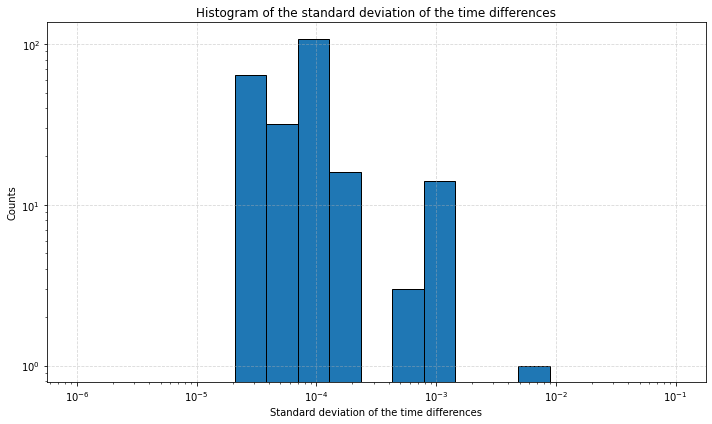

In [30]:
plt.figure(figsize=(10, 6))
plt.grid(True, linestyle='--', alpha=0.5)
plt.hist(stds, bins=np.logspace(-6, -1, 20), edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Standard deviation of the time differences')
plt.ylabel('Counts')
plt.title('Histogram of the standard deviation of the time differences')
plt.tight_layout()
plt.show()

Found 196 bad times
id: 87, t.shape: (129171,), d.shape: (129171,)
Nan t: 0, Nan d: 0


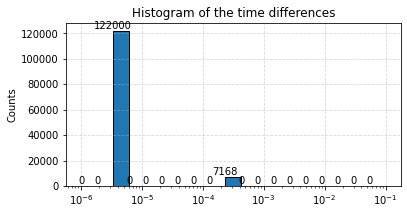

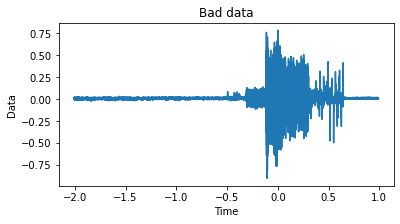

id: 183, t.shape: (194002,), d.shape: (194002,)
Nan t: 0, Nan d: 0


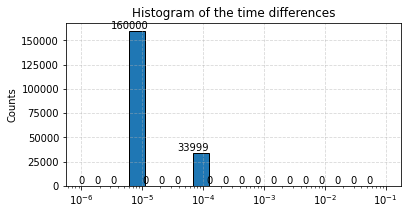

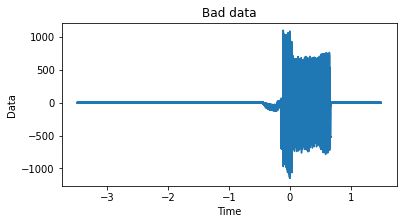

id: 183, t.shape: (194002,), d.shape: (194002,)
Nan t: 0, Nan d: 0


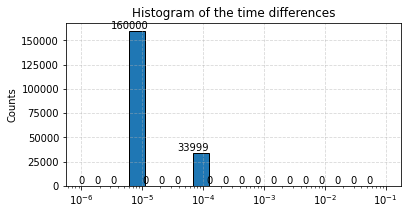

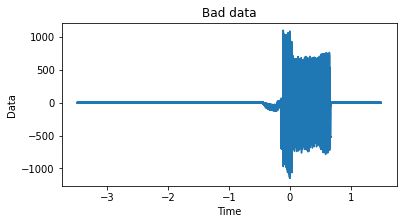

id: 81, t.shape: (129171,), d.shape: (129171,)
Nan t: 0, Nan d: 0


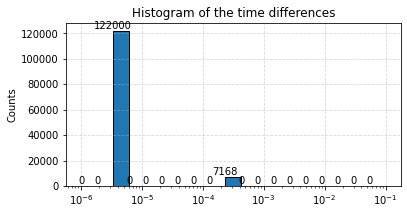

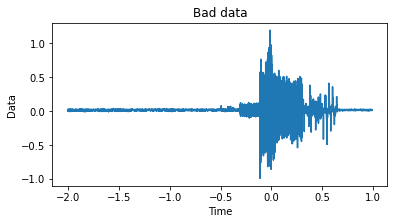

id: 171, t.shape: (194002,), d.shape: (194002,)
Nan t: 0, Nan d: 0


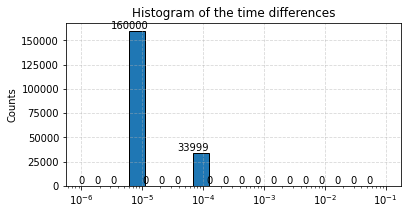

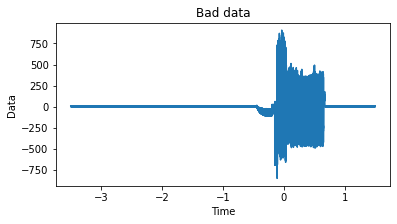

id: 153, t.shape: (127003,), d.shape: (127003,)
Nan t: 0, Nan d: 0


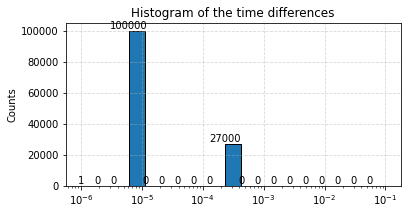

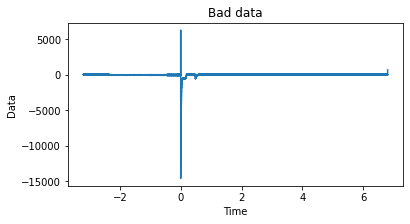

id: 185, t.shape: (194002,), d.shape: (194002,)
Nan t: 0, Nan d: 0


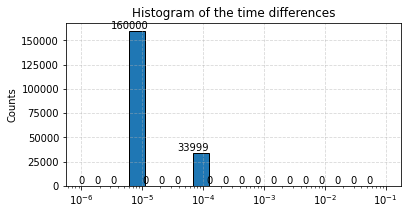

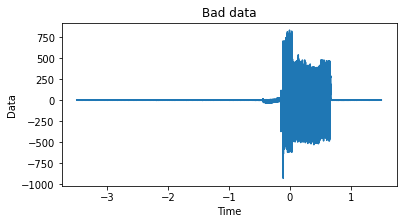

id: 86, t.shape: (129171,), d.shape: (129171,)
Nan t: 0, Nan d: 0


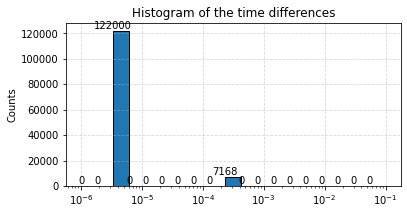

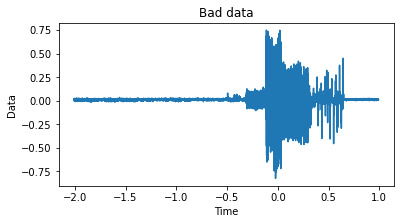

id: 85, t.shape: (129171,), d.shape: (129171,)
Nan t: 0, Nan d: 0


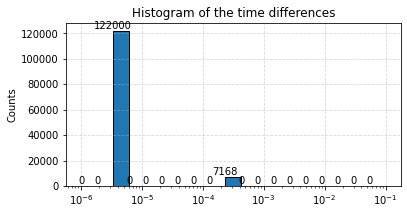

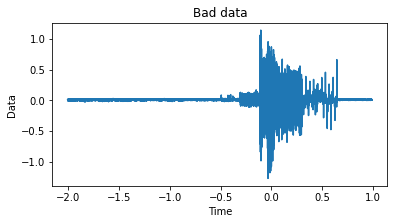

id: 88, t.shape: (129171,), d.shape: (129171,)
Nan t: 0, Nan d: 0


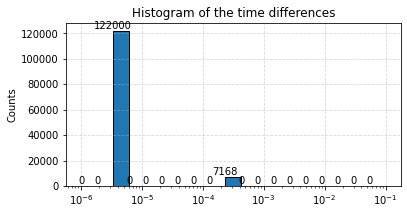

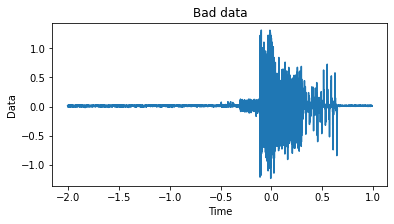

id: 150, t.shape: (207002,), d.shape: (207002,)
Nan t: 0, Nan d: 0


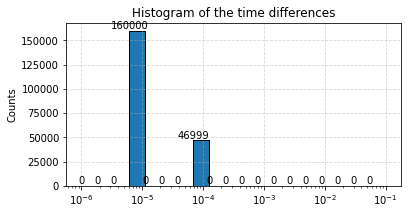

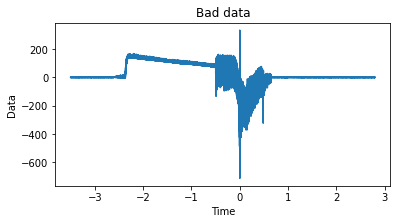

id: 81, t.shape: (129171,), d.shape: (129171,)
Nan t: 0, Nan d: 0


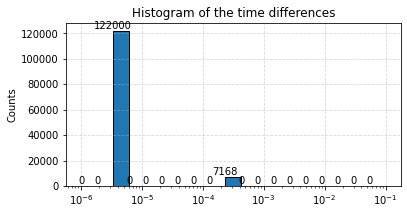

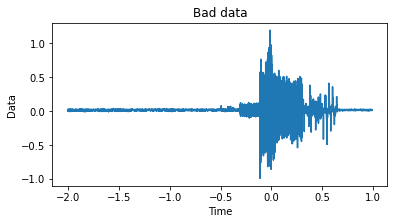

id: 143, t.shape: (127003,), d.shape: (127003,)
Nan t: 0, Nan d: 0


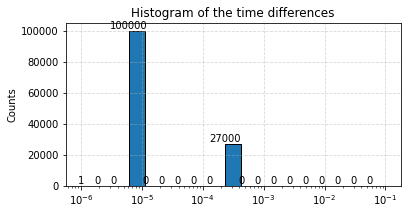

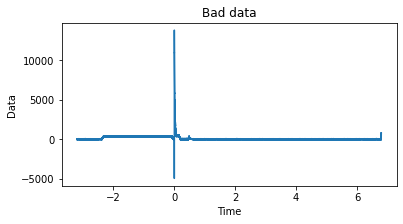

id: 94, t.shape: (129171,), d.shape: (129171,)
Nan t: 0, Nan d: 0


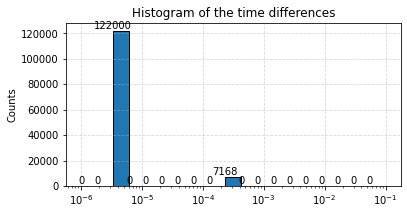

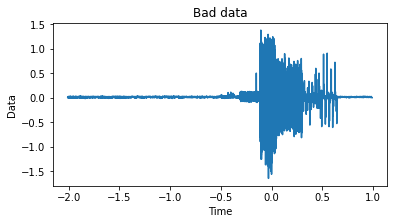

id: 166, t.shape: (194002,), d.shape: (194002,)
Nan t: 0, Nan d: 0


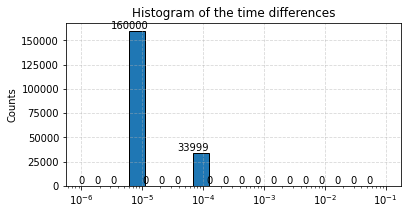

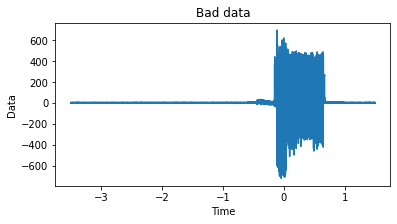

In [36]:
# pick bad times: high std of diff
%matplotlib inline
bad_times, bad_datas = [], []
for t, d, std in zip(times, datas, times_diff_stds):
    if std > 1e-6 and len(t)>100000: bad_times.append(t), bad_datas.append(d)
print(f'Found {len(bad_times)} bad times')
#select N random indices
N = 5
indices = np.random.choice(len(bad_times), N)
for i in indices:
    t,d = bad_times[i], bad_datas[i]
    print(f'id: {i}, t.shape: {t.shape}, d.shape: {d.shape}')
    diff = np.diff(t) # get the differences between the time vector, the deltas
    #plot histogram if diff
    plt.figure(figsize=(6, 3))
    bins = np.logspace(-6, -1, 20)
    counts, bins, _ = plt.hist(diff, bins=bins, edgecolor='black')
    plt.ylabel('Counts')
    plt.title('Histogram of the time differences')
    plt.grid(True, linestyle='--', alpha=0.5)
    for i, count in enumerate(counts):
        plt.text(bins[i], count, str(int(count)), ha='center', va='bottom')
    plt.xscale('log')
    # plt.show()
    #plot the data vector
    plt.figure(figsize=(6, 3))
    plt.plot(t, d)
    plt.title('Bad data')
    plt.xlabel('Time')
    plt.ylabel('Data')
    plt.show()

In [32]:
# get the mea